<h1>Random Forest Regressor model 

Trying https://www.kaggle.com/datasets/mohithsairamreddy/salary-data/code?select=Salary_Data.csv <br>
A dataset focused on salaries 

In [372]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [373]:
# Salaries dataset
df_s=pd.read_csv('../Datasets/Salary_Data.csv')
df_s.head(-5)

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6694,27.0,Male,High School,Digital Marketing Manager,2.0,40000.0
6695,33.0,Female,Bachelor's Degree,Content Marketing Manager,7.0,90000.0
6696,28.0,Male,PhD,Sales Representative,4.0,55000.0
6697,51.0,Female,Master's Degree,Senior Product Marketing Manager,19.0,190000.0


So we have 6 important columns: Age, Gender, Education Level, Job Title, Experience and Salary<br>
How many unique values are for each column and do they need preprocessing?

In [374]:
print('Age column:',df_s['Age'].unique())
# Age has nan values also
print('Gender column:',df_s.Gender.unique())
# Gender contains nan values
print('Education Level column:',df_s['Education Level'].unique())
# So we have Bachelor's, Master's and phD twice and also nan values
print('Job Title column:',df_s['Job Title'].unique())
# There are many jobs such as:  'Juniour HR Generalist' ...Juniour? French job?
print('Years of Experience column:',df_s['Years of Experience'].unique())
# Contains nan values as well as 0, 0 years of experience makes sense
# But nan values do not really mean no experience so can't transform nan into 0s
print('Salary column:',df_s['Salary'].unique())
# The last column seems to not contain nan values but should still preprocess it to be sure.


Age column: [32. 28. 45. 36. 52. 29. 42. 31. 26. 38. 48. 35. 40. 27. 44. 33. 39. 25.
 51. 34. 47. 30. 41. 37. 24. 43. 50. 46. 49. 23. 53. nan 61. 57. 62. 55.
 56. 54. 60. 58. 22. 21.]
Gender column: ['Male' 'Female' nan 'Other']
Education Level column: ["Bachelor's" "Master's" 'PhD' nan "Bachelor's Degree" "Master's Degree"
 'High School' 'phD']
Job Title column: ['Software Engineer' 'Data Analyst' 'Senior Manager' 'Sales Associate'
 'Director' 'Marketing Analyst' 'Product Manager' 'Sales Manager'
 'Marketing Coordinator' 'Senior Scientist' 'Software Developer'
 'HR Manager' 'Financial Analyst' 'Project Manager' 'Customer Service Rep'
 'Operations Manager' 'Marketing Manager' 'Senior Engineer'
 'Data Entry Clerk' 'Sales Director' 'Business Analyst' 'VP of Operations'
 'IT Support' 'Recruiter' 'Financial Manager' 'Social Media Specialist'
 'Software Manager' 'Junior Developer' 'Senior Consultant'
 'Product Designer' 'CEO' 'Accountant' 'Data Scientist'
 'Marketing Specialist' 'Technical 

In [375]:
len(df_s)

6704

Preprocessing 

In [376]:
# Function to detect how many nan values a column has
def nan_values(column):
    column=column.isnull().sum()+column.isna().sum() # .isnull() does not detect nan values
    return column

print('Age nulls: ',nan_values(df_s.Age))
print('Gender nulls: ',nan_values(df_s.Gender))
print('Education nulls: ',nan_values(df_s['Education Level']))
print('Job nulls: ',nan_values(df_s['Job Title']))
print('Exp nulls: ',nan_values(df_s['Years of Experience']))
print('Salary nulls: ',nan_values(df_s['Salary']))

# The best course of action is to just drop those rows since they are only a handful anyway

Age nulls:  4
Gender nulls:  4
Education nulls:  6
Job nulls:  4
Exp nulls:  6
Salary nulls:  10


In [377]:
# Function to drop rows with nan values
# or could have simply called df_s=df_s.dropna()
def drop_rows_with_nan(df,columns):
    for columns in columns:
        df = df.dropna(subset=[columns])
    return df

df_s=drop_rows_with_nan(df_s, ['Age','Gender','Education Level', 'Job Title', 'Years of Experience', 'Salary'])
# testing if func worked
print('Salary nulls: ',nan_values(df_s['Salary']))

Salary nulls:  0


In [378]:
# Addressing the repeating Education Levels
df_s['Education Level'] = df_s['Education Level'].replace({"Bachelor's Degree": "Bachelor's"})
df_s['Education Level'] = df_s['Education Level'].replace({"Master's Degree": "Master's"})
df_s['Education Level'] = df_s['Education Level'].replace({"phD": "PhD"})
print(df_s['Education Level'].unique())

["Bachelor's" "Master's" 'PhD' 'High School']


Does education correlate to a higher income?<br>
Finding first the correlation between columns:

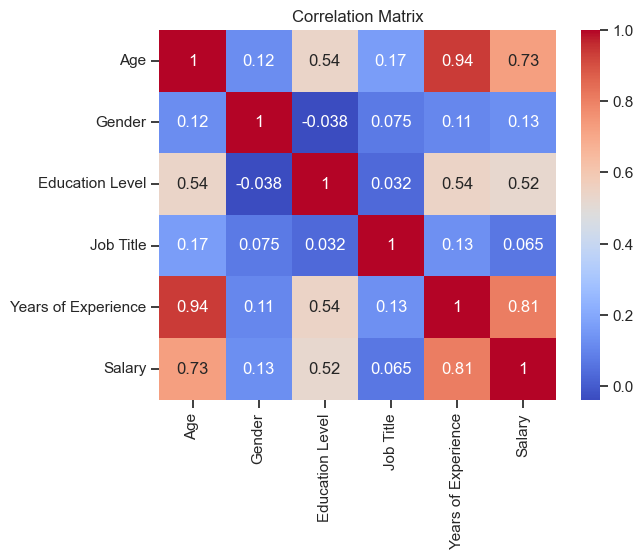

In [379]:
# Encoding 
le_gender = LabelEncoder()
le_education = LabelEncoder()
le_job = LabelEncoder()
df_s['Gender'] = le_gender.fit_transform(df_s['Gender'])
df_s['Education Level'] = le_education.fit_transform(df_s['Education Level'])
df_s['Job Title'] = le_job.fit_transform(df_s['Job Title'])

correlation = df_s.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
# The most correlated values:
# Age with Years of Experience and Salary
# Years of Experience with Salary

# The most uncorrelated columns:
# Gender
# Job title

# Education level holds a middle ground here

In [380]:
# inverse transforming the Education Level Column first
df_s['Education Level']=le_education.inverse_transform(df_s['Education Level'])

# it seems like the 'worst' 4 jobs have a wrong salary value
# Eliminating those rows:
df_s = df_s[df_s['Salary'] >= 1000]

# Selecting education level and salary and creating a separate df for each
bachelor=df_s[df_s['Education Level']=="Bachelor's"][['Education Level', 'Salary']]
phd=df_s[df_s['Education Level']=="PhD"][['Education Level', 'Salary']]
master=df_s[df_s['Education Level']=="Master's"][['Education Level', 'Salary']]
highschool=df_s[df_s['Education Level']=="High School"][['Education Level', 'Salary']]

# Average salaries for each education level
bachelor_mean_salary = bachelor['Salary'].mean().round()
phd_mean_salary = phd['Salary'].mean().round()
master_mean_salary = master['Salary'].mean().round()
highschool_mean_salary = highschool['Salary'].mean().round()

# Printing out results.
print('Mean Bachelor`s salary:',bachelor_mean_salary )
print('Mean Master`s salary:',master_mean_salary)
print('Mean PhD salary:',phd_mean_salary)
print('Mean High Schooler salary:',highschool_mean_salary)
print('Difference between a PhD and an High Schooler: ',phd_mean_salary-highschool_mean_salary)

Mean Bachelor`s salary: 95177.0
Mean Master`s salary: 130112.0
Mean PhD salary: 165772.0
Mean High Schooler salary: 36707.0
Difference between a PhD and an High Schooler:  129065.0


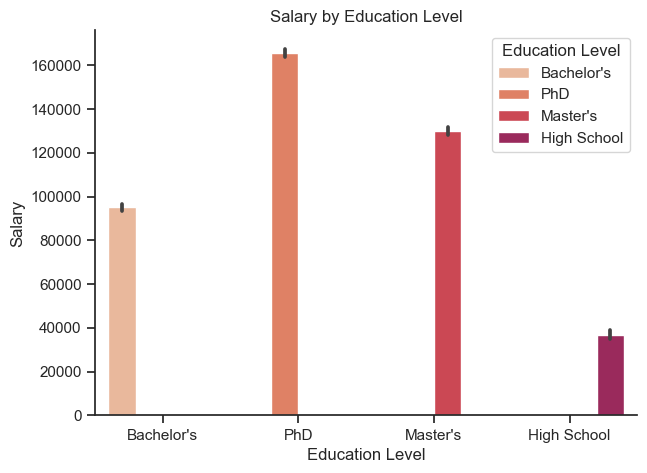

In [381]:
# Combine the salary data for all education levels
data = pd.concat([bachelor, phd, master, highschool])
labels = ["Bachelor's", "PhD", "Master's", "High School"]

# Create the scatter plot
palette = sns.color_palette("rocket_r")
sns.set_theme(style='ticks')
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(data=data, x='Education Level', y='Salary', hue='Education Level',
                palette=palette,
               )

# Customize the plot
ax.set_xlabel('Education Level')
ax.set_ylabel('Salary')
ax.set_title('Salary by Education Level')

plt.show()

Answer: Yes <br>
Better education does correlate with a better overall salary

How much does the highest job pay? How low does the lowest job pay? What is that job's title?

In [382]:
df_s['Job Title'] = le_job.inverse_transform(df_s['Job Title'])
df_s[['Job Title', 'Salary']].sort_values(by='Salary', ascending=True)

,Job Title,Salary
5819,Receptionist,25000.0
4461,Junior Sales Associate,25000.0
4471,Junior Sales Associate,25000.0
4476,Junior Sales Associate,25000.0
4486,Junior Sales Associate,25000.0
...,...,...
4291,Data Scientist,240000.0
4276,Data Scientist,240000.0
83,Chief Technology Officer,250000.0
30,CEO,250000.0


In [383]:
# Since I inverse transformed 2 columns, need to transform them back to numerical values.
df_s['Education Level'] = le_education.fit_transform(df_s['Education Level'])
df_s['Job Title'] = le_job.fit_transform(df_s['Job Title'])

In [384]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict salaries for the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Training predictions: ', y_train_pred.round())
print('Testing predictions: ', y_test_pred.round())

Training predictions:  [126242. 138722. 110000. ...  54520. 186820.  90000.]
Testing predictions:  [178755. 125000.  72090. ... 131969. 144711. 111860.]
